## Imports

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from operator import itemgetter
from collections import Counter
import random
from tqdm import tqdm
tqdm.pandas()
from itertools import product

In [36]:
N = 500
M = 1000
p = M / (N*(N-1)/2)
gamma = 2.128

degree_distribution = nx.utils.random_sequence.powerlaw_sequence(N, gamma, seed=42)

In [3]:
G_sf = nx.expected_degree_graph(degree_distribution, seed=42, selfloops=False)
# G_sf = nx.barabasi_albert_graph(N, 2)
# G_er = nx.erdos_renyi_graph(N, p, seed=None, directed=False)

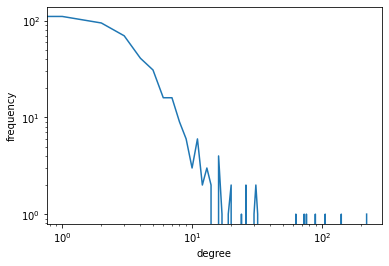

In [ ]:
counts = Counter(d for n, d in G_sf.degree())
degree_freq = [counts.get(i, 0) for i in range(max(counts) + 1)]

plt.loglog(range(len(degree_freq)), degree_freq)
plt.xlabel('degree')
plt.ylabel('frequency')
plt.show()

In [4]:
def initialize_graph(G, seed=0):
    # Set percolation state of all nodes to 0
    nx.set_node_attributes(G, 1e-6, name='curr_state')
    nx.set_node_attributes(G, 1e-6, name='new_state')

    # Initialize spreading at a random node. !! no spreading from isolated nodes
    np.random.seed(seed)
    initial_node = np.random.choice(G.nodes)
    while(initial_node not in next(nx.connected_components(G))):
        initial_node = np.random.choice(G.nodes)
    
    G.nodes[initial_node]['curr_state'] = 1
    G.nodes[initial_node]['new_state'] = 1
    return G

In [5]:
def compute_ratio(G):
    PC = nx.percolation_centrality(G, attribute='curr_state')
    BC = nx.betweenness_centrality(G)
    BC_avg = 0
    PC_avg = 0
    counter = 0
    for node in G.nodes:
      if BC[node] > 0:
        BC_avg += BC[node]
        PC_avg += PC[node]
        counter += 1
    BC_avg = float(BC_avg / counter)
    PC_avg = float(PC_avg / counter)
    return PC_avg / BC_avg

In [6]:
def hop_centrality(G):
    percolated_nodes = set([key for key, value in nx.get_node_attributes(G, 'curr_state').items() if value==1])
    centrality = {}

    for source in G.nodes:
        for distance in range(G.number_of_nodes()+1):
            descendants = nx.descendants_at_distance(G, source, distance)
            if(set(descendants) & percolated_nodes):
                centrality[source] = distance
                break
    return centrality

In [7]:
def immunize(G, beta, measure):
    if(measure=='PC'):
        centrality = nx.percolation_centrality(G, attribute='curr_state')
        centrality = sorted(centrality, key=centrality.get, reverse=True)
    elif(measure=='BC'):
        centrality = nx.betweenness_centrality(G)
        centrality = sorted(centrality, key=centrality.get, reverse=True)
    elif(measure=='HD'):
        centrality = hop_centrality(G)
        centrality = sorted(centrality, key=centrality.get)
    else:
        ValueError('Centrality measure not supported')

    percolated_nodes = [key for key, value in nx.get_node_attributes(G, 'curr_state').items() if value==1]
    for percolated_node in percolated_nodes:
        centrality.remove(percolated_node)

    N = G.number_of_nodes()
    immunized_nodes = centrality[:int(N * beta / 100)]
    G.remove_nodes_from(immunized_nodes)
    return G

In [8]:
def percolate(G, perc_prob, seed, timesteps=70, compute_ratios=False, alpha=100, beta=0, measure='PC', saturation_threshold=1000, verbose=0):
    G = G.copy()
    N = G.number_of_nodes()
    num_infected = []
    ratios = []
    curr_infected = 1
    immunized = False
    saturated = False
    # Max saturation time
    saturation_time = 50
    random.seed(seed)

    cs = nx.get_node_attributes(G, 'curr_state')
    initial_node = max(cs, key=cs.get)
    verbose and print('Initial degree', G.degree(initial_node))
    max_deg = G.degree(initial_node)

    num_infected.append(curr_infected)
    if compute_ratios:
        ratios.append(compute_ratio(G))
        verbose and print(f'Timestep {0} - num infected {curr_infected}, ratio {ratios[-1]}, max degree {max_deg}')
    else:
        verbose and print(f'Timestep {0} - num infected {curr_infected}, max degree {max_deg}')
    for timestep in range(1, timesteps+1):
        for node_key, node in G.nodes(data=True):
            if(node['curr_state'] == 1):
                continue
            neighbs = G.adj[node_key]
            for neighbor in neighbs:
                if G.nodes[neighbor]['curr_state'] == 1:
                    random_var = random.uniform(0, 1)
                    if random_var < perc_prob:
                        node['new_state'] = 1
                        max_deg = max(max_deg, G.degree[node_key])
                        curr_infected = curr_infected + 1
                        break

        for _, node in G.nodes(data=True):
            node['curr_state'] = node['new_state']

        num_infected.append(curr_infected)
        if compute_ratios:
            ratios.append(compute_ratio(G))
            verbose and print(f'Timestep {timestep} - num infected {curr_infected}, ratio {ratios[-1]}, max degree {max_deg}')
        else:
            verbose and print(f'Timestep {timestep} - num infected {curr_infected}, max degree {max_deg}')

        if(immunized and not saturated and curr_infected >= saturation_threshold):
            saturated = True
            saturation_time = timestep - immunization_timestep
            verbose and print(f'Saturation reached at timestep {timestep}, after {saturation_time} step from immunization')
        if(not immunized and curr_infected / N * 100 >= alpha):
            G = immunize(G, beta, measure)
            immunized = True
            immunization_timestep = timestep
            verbose and print(f'Immunization happening at time {timestep}')

    return num_infected, ratios, saturation_time

Initial degree 3
Timestep 0 - num infected 1, max degree 3
Timestep 1 - num infected 2, max degree 221
Timestep 2 - num infected 44, max degree 221
Timestep 3 - num infected 114, max degree 221
Timestep 4 - num infected 210, max degree 221
Timestep 5 - num infected 274, max degree 221
Timestep 6 - num infected 322, max degree 221
Timestep 7 - num infected 356, max degree 221
Timestep 8 - num infected 373, max degree 221
Timestep 9 - num infected 392, max degree 221
Timestep 10 - num infected 401, max degree 221
Timestep 11 - num infected 402, max degree 221
Timestep 12 - num infected 411, max degree 221
Timestep 13 - num infected 417, max degree 221
Timestep 14 - num infected 422, max degree 221
Timestep 15 - num infected 423, max degree 221
Timestep 16 - num infected 425, max degree 221
Timestep 17 - num infected 426, max degree 221
Timestep 18 - num infected 427, max degree 221
Timestep 19 - num infected 427, max degree 221
Timestep 20 - num infected 428, max degree 221
Timestep 21 -

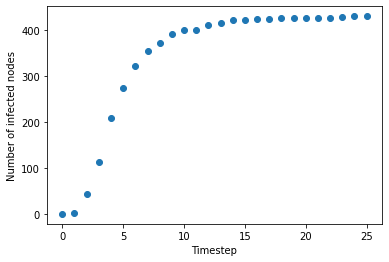

In [9]:
timesteps = 25

G_sf = initialize_graph(G_sf, 4)
num_infected, _, saturation_time = percolate(G_sf, perc_prob=.2, seed=1, timesteps=timesteps, compute_ratios=False, verbose=1)
plt.scatter(np.arange(timesteps+1), num_infected)
plt.xlabel('Timestep')
plt.ylabel('Number of infected nodes')
plt.show()

In [10]:
def compute_iterations(kind, alpha, beta, measures, saturation_threshold, repetitions=5, perc_prob=0.2, verbose=0):
    iterations = []
    iterations = np.empty((len(measures), repetitions))
    for r in range(repetitions):
        seed = random.randint(1, 100000)
        if(kind == 'scale-free'):
            degree_distribution = nx.utils.random_sequence.powerlaw_sequence(N, gamma)
            G = nx.expected_degree_graph(degree_distribution, seed=seed, selfloops=False)
            # G = nx.barabasi_albert_graph(N, 2)
        elif(kind == 'erdos-ranyi'):
            G = nx.erdos_renyi_graph(N, p, seed=seed, directed=False)
        else:
            ValueError('Kind of graph not implemented')
        for i, measure in enumerate(measures):
            G = initialize_graph(G, seed).copy()
            _, _, iters = percolate(G, perc_prob, seed, timesteps=100, compute_ratios=False, 
                                    alpha=alpha, beta=beta, measure=measure, saturation_threshold=saturation_threshold, verbose=verbose)
            iterations[i, r] = iters
    return iterations.mean(axis=1)

In [20]:
alphas = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25]
betas = [1] + list(alphas[:-1])

alphas, betas = list(zip(*list(product(alphas, betas))))
results = pd.DataFrame({'alpha': alphas, 'beta': betas})

results['iterations'] = results.progress_apply(lambda x: compute_iterations('scale-free', x.alpha, x.beta, ['PC', 'BC', 'HD'], 350, repetitions=10), axis=1)

100%|██████████| 196/196 [1:12:38<00:00, 22.24s/it]


## Save data

In [11]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')\

Mounted at /content/drive


In [12]:
DRIVE_PATH = '/content/drive/MyDrive/NooC project/'

In [35]:
# Save results
results.to_parquet(DRIVE_PATH + f'results_erdos_remyi_{p}.parquet')
# results.to_parquet(DRIVE_PATH + f'results_barabasi_2.parquet')
# results.to_parquet(DRIVE_PATH + f'scale-free_{gamma}.parquet')

In [31]:
gamma = 1.5

In [37]:
# Load results
results = pd.read_parquet(DRIVE_PATH + f'results_erdos_remyi_{p}.parquet')
# results = pd.read_parquet(DRIVE_PATH + f'results_barabasi_2.parquet')
# results = pd.read_parquet(DRIVE_PATH + f'results_Neta.parquet')
# results = pd.read_parquet(DRIVE_PATH + f'scale-free_{gamma}.parquet')

In [17]:
def process_results(results):
    results[['PC', 'BC', 'HD']] = results.iterations.agg([itemgetter(0), itemgetter(1), itemgetter(2)]).values
    results = results.drop('iterations', axis=1)
    results = pd.melt(results, id_vars=['alpha', 'beta'], value_vars=['PC', 'BC', 'HD'], var_name='measure')
    table = results.pivot(['alpha', 'measure'], 'beta', 'value')

    idmaxs = results.groupby(['alpha', 'beta']).value.idxmax()
    heatmap1 = results.loc[idmaxs].pivot('alpha', 'beta', 'measure')

    idmaxs = results[::-1].groupby(['alpha', 'beta']).value.idxmax()
    heatmap2 = results.loc[idmaxs].pivot('alpha', 'beta', 'measure')

    heatmap = (heatmap1.replace({'HD': 1, 'PC': 2, 'BC':3}) + heatmap2.replace({'HD': 1, 'PC': 2, 'BC':3})) / 2

    fig = plt.subplots(figsize=(6, 5))
    cm = LinearSegmentedColormap.from_list('my_cmap', ['darkblue', 'deepskyblue', 'chartreuse', 'orange', 'darkred'], N=100)
    ax = sns.heatmap(heatmap, cmap=cm)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([1, 2, 3])
    cbar.set_ticklabels(['HD', 'PC', 'BC'])
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\alpha$', rotation=0)
    plt.yticks(rotation=0)
    return table

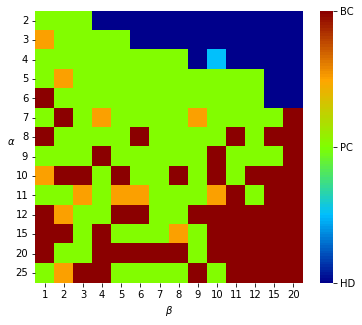

In [39]:
table = process_results(results)
plt.savefig(DRIVE_PATH + 'erdos_ranyi_ours.pdf', bbox_inches='tight', pad=0.0)